# Import data 

In [69]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [49]:
print(len(train.columns))
print(len(test.columns))

12
11


# Preprocessing data 

In [70]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df


In [51]:

def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex'])
    return df

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [71]:
train = preprocess(train)
test = preprocess(test)

In [72]:
print(len(train.columns))
print(len(test.columns))

43
41


In [55]:
col1 = set(train.columns)
col2 = set(test.columns)
col1 - col2

{'Cabin_type_T', 'Survived'}

In [73]:
test['Cabin_type_T'] = 0
print(len(train.columns))
print(len(test.columns))

43
42


# Exploring data

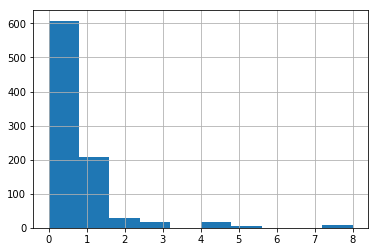

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

train['SibSp'].hist()

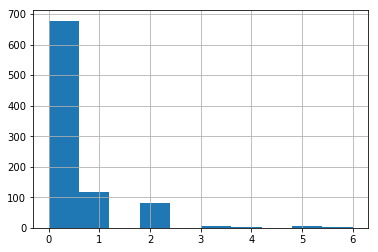

In [10]:
train['Parch'].hist()

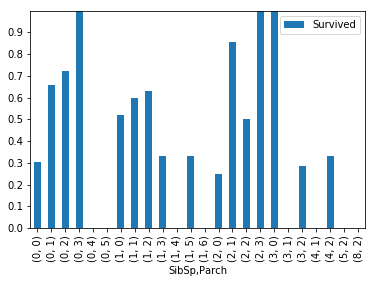

In [57]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=["SibSp","Parch"],values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [75]:
def isalone(row):
    if row['SibSp'] + row['Parch'] == 0:
        return 1
    else: 
        return 0
    
train['isalone'] = train.apply(isalone, axis=1)
test['isalone'] = test.apply(isalone, axis=1)

In [76]:
print(len(train.columns))
print(len(test.columns))

44
43


# Select best-performance features 

In [61]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [74]:
def select_features(df):
    df = df.dropna(axis=1)
    df = df.select_dtypes([np.int64, np.float64, np.uint8])
    columns = list(df.columns)
    columns.remove('Survived')
    columns.remove('PassengerId')
    all_x = df[columns]
    all_y = df['Survived']
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc, cv=10 )
    selector.fit(all_x, all_y)
    best_cols = all_x.columns[selector.support_]
    return list(best_cols)


In [77]:
best_cols = select_features(train)

In [66]:
best_cols

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Adult',
 'Age_categories_Child',
 'Age_categories_Infant',
 'Age_categories_Missing',
 'Age_categories_Senior',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Fare_categories_0-12',
 'Fare_categories_100+',
 'Fare_categories_50-100',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Officer',
 'Cabin_type_B',
 'Cabin_type_C',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'isalone',
 'Survived']

In [78]:
import copy
all_cols = copy.deepcopy(best_cols)
all_cols.append('Survived')
best_cols

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Adult',
 'Age_categories_Child',
 'Age_categories_Infant',
 'Age_categories_Missing',
 'Age_categories_Senior',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Fare_categories_0-12',
 'Fare_categories_100+',
 'Fare_categories_50-100',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Officer',
 'Cabin_type_B',
 'Cabin_type_C',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'isalone']

In [79]:
train = train[all_cols]
test = test[best_cols]
print(len(train.columns))
print(len(test.columns))

29
28


# Select algorithms 

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [19]:
# def  select_model(df):
#     all_x = df[best_cols]
#     all_y = df['Survived']
#     hyper_lr = {"solver": ["newton-cg", "lbfgs", "liblinear"] }
#     hyper_knn = {"n_neighbors": range(1,20,2), "weights": ["distance", "uniform"], "algorithm": ["ball_tree", "kd_tree", "brute"], "p": [1,2]}
#     hyper_rfc = {"n_estimators": [4, 6, 9],"criterion": ["entropy", "gini"],"max_depth": [2, 5, 10],  "max_features": ["log2", "sqrt"], "min_samples_leaf": [1, 5, 8], "min_samples_split": [2, 3, 5]}
#     lr = LogisticRegression()
#     knn = KNeighborsClassifier()
#     rfc = RandomForestClassifier()
#     models = [{'name': 'lr', 'estimator': lr, 'hyper': hyper_lr}, {'name':'knn', 'estimator':knn, 'hyper':hyper_knn}, {'name':'rfc', 'estimator':rfc, 'hyper':hyper_rfc}]
#     for model in models:
#         grid = GridSearchCV(model['estimator'], param_grid=model['hyper'], cv=10)
#         grid.fit(all_x, all_y)
#         model['best_params'] = grid.best_params_
#         model['best_score'] = grid.best_score_
#     return models

In [20]:
# result = select_model(train)
# for model in result:
#     print(model['name'])
#     print(model['best_score'])
#     print(model['best_params'])

lr
1.0
{'solver': 'newton-cg'}
knn
0.852974186308
{'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}
rfc
0.998877665544
{'min_samples_leaf': 1, 'n_estimators': 9, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10}


In [80]:
model = RandomForestClassifier(min_samples_leaf=1, n_estimators=9, min_samples_split = 2, criterion='entropy', max_features='sqrt', max_depth=10)
model.fit(train[best_cols], train['Survived'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [81]:
predictions = model.predict(test)

In [82]:
len(predictions)

418

In [83]:
id_data = pd.read_csv('test.csv')
test_id = id_data['PassengerId']
submission_df = {'PassengerId':test_id, 'Survived':predictions}
submission = pd.DataFrame(submission_df)

In [84]:
submission.to_csv('submission.csv', index=False)